In [1]:
# this attempts to do the same thing as the otoro blog, but with a delta distribution instead
# http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from tqdm import tnrange, tqdm_notebook

In [3]:
NHIDDEN = 24
STDEV = 0.5
KMIX = 24 # number of mixtures
NOUT = KMIX * 1 # delta center

NSAMPLE = 2400

In [4]:
y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1))) # random noise
x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)

In [5]:
x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

Wh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))
bh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))

Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))
bo = tf.Variable(tf.random_normal([1,NOUT], stddev=STDEV, dtype=tf.float32))

In [6]:
hidden_layer = tf.nn.tanh(tf.matmul(x, Wh) + bh)
output = tf.matmul(hidden_layer,Wo) + bo

In [7]:
def get_mixture_coef(output):
    out_d = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    
    out_d = tf.scalar_mul(1, output)
    
    return out_d

In [8]:
out_d = get_mixture_coef(output)

In [9]:
def tf_normal(y, d):
    result = tf.subtract(y, d)
    
    return result

def get_lossfunc(out_d, y):
    result = tf_normal(y, out_d)
    
    return tf.reduce_mean(result)

In [10]:
lossfunc = get_lossfunc(out_d, y)
train_op = tf.train.AdamOptimizer().minimize(lossfunc)

In [11]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

NEPOCH = 10000
loss = np.zeros(NEPOCH)

for i in tnrange(NEPOCH, desc='epoch #'):
    sess.run(train_op,feed_dict={x: x_data, y: y_data})
    loss[i] = sess.run(lossfunc, feed_dict={x: x_data, y: y_data})
    
    if i == NEPOCH - 1:
        net_out = tf.Tensor.eval(out_d,feed_dict={x: x_data, y: y_data})

A Jupyter Widget

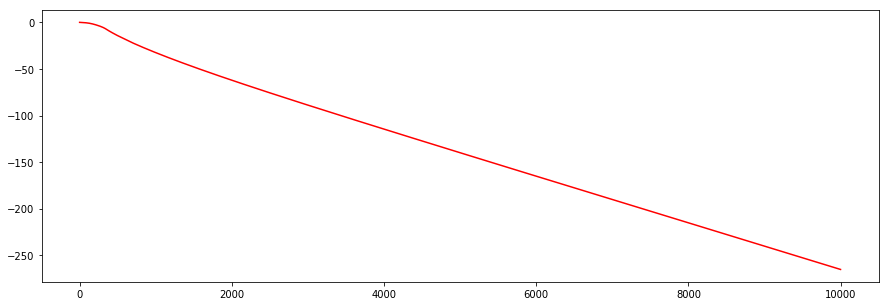

In [12]:
plt.figure(figsize=(15, 5))
#plt.plot(np.arange(100, NEPOCH,1), loss[100:], 'r-')
plt.plot(range(NEPOCH), loss, 'r-')
plt.show()

In [13]:
net_out

array([[ 262.50003052,  267.59674072,  263.93273926, ...,  266.86956787,
         264.43896484,  263.08297729],
       [ 262.5017395 ,  267.59848022,  263.93444824, ...,  266.87127686,
         264.44067383,  263.08465576],
       [ 262.50048828,  267.597229  ,  263.93322754, ...,  266.87005615,
         264.43948364,  263.08343506],
       ..., 
       [ 262.50057983,  267.59732056,  263.93328857, ...,  266.87014771,
         264.43951416,  263.08352661],
       [ 262.5       ,  267.59667969,  263.93267822, ...,  266.86950684,
         264.43887329,  263.08285522],
       [ 262.50152588,  267.59829712,  263.93423462, ...,  266.87109375,
         264.44049072,  263.08444214]], dtype=float32)

In [14]:
num = 2000

print(x_data[num])
print(y_data[num])
print(net_out[num])

[-0.06538031]
[ 4.56152773]
[ 262.5007019   267.59744263  263.93344116  266.63684082  263.84078979
  263.16619873  262.74029541  263.8248291   265.80252075  266.24563599
  266.29623413  265.84729004  267.54406738  266.87280273  262.89303589
  265.93862915  270.17858887  261.65774536  269.90014648  265.1338501
  263.79641724  266.87026978  264.43966675  263.08361816]


In [15]:
print('x:', np.transpose(x_data[np.where((x_data > -0.1) & (x_data < 0.1))[0]]))
print('y:', np.transpose(y_data[np.where((x_data > -0.1) & (x_data < 0.1))[0]]))

x: [[ 0.08311957  0.08993447  0.06888929 -0.09042084 -0.01060623 -0.09154177
   0.07869822 -0.08213818  0.00034899  0.07514888  0.06173253  0.04726446
   0.03970385  0.04960857 -0.0702396   0.03164601 -0.0481478   0.06022677
   0.01655167 -0.07234132 -0.01420772 -0.08414419 -0.06538031  0.08924884
  -0.03140551 -0.01324266 -0.02500328]]
y: [[-7.57101917  4.8587184   0.03850928 -5.03976107  7.723773   -7.06494331
  -7.53115273  7.74104309 -4.83856153 -4.81238461  4.94115829  4.44353294
   4.79746008 -7.61507607 -7.48624182  4.40511894 -4.38429308 -0.05932654
  -0.02735645  7.74230194  4.78384209 -4.65701246  4.56152773  4.79076529
  -7.48871231  4.806108    4.63231707]]


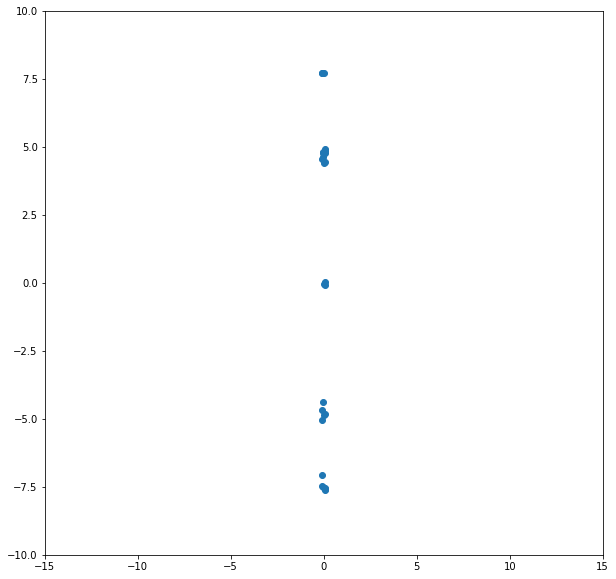

In [16]:
plt.figure(figsize=(10,10))

plt.scatter(x_data[np.where((x_data > -0.1) & (x_data < 0.1))[0]], y_data[np.where((x_data > -0.1) & (x_data < 0.1))[0]])

plt.xlim(-15,15)
plt.ylim(-10,10)
plt.show()

In [17]:
x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

In [18]:
def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print('error with sampling ensemble')
    return -1

def generate_ensemble(out_d, M = 10):
    NTEST = x_test.size
    result = np.random.rand(NTEST, M) # initially random [0, 1]
    rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
    idx = 0

    # transforms result into random ensembles
    for j in range(0, M):
        for i in range(0, NTEST):
            idx = get_pi_idx(result[i, j], out_d[i])
            result[i, j] = rn[i, j]
    return result

In [19]:
for j in range(0,10):
    for i in range(0,NTEST):
        print(get_pi_idx(np.random.rand(NTEST, 10)[i, j], net_out[i]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [20]:
net_out[1]

array([ 262.5017395 ,  267.59848022,  263.93444824,  266.63781738,
        263.84176636,  263.16717529,  262.74130249,  263.82583618,
        265.80355835,  266.24667358,  266.29730225,  265.84829712,
        267.54507446,  266.8737793 ,  262.89404297,  265.93969727,
        270.17965698,  261.65875244,  269.9012146 ,  265.13485718,
        263.79742432,  266.87127686,  264.44067383,  263.08465576], dtype=float32)

In [22]:
out_d_test = sess.run(get_mixture_coef(output), feed_dict={x: x_test})

y_test = generate_ensemble(out_d_test)

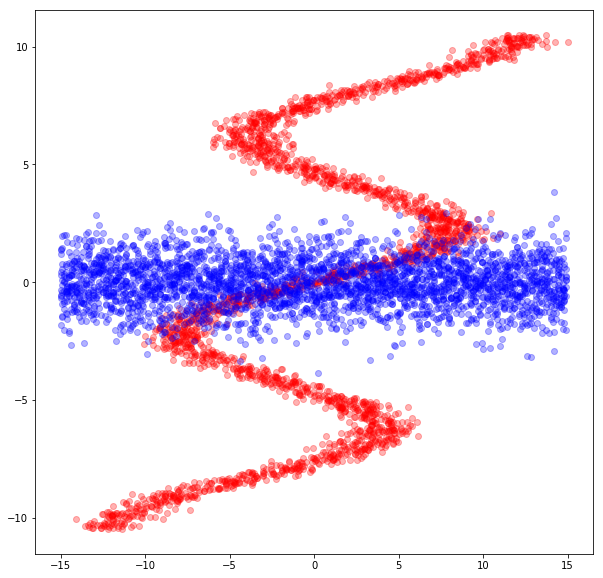

In [23]:
plt.figure(figsize=(10,10))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()